## Data collection

*Document your data collection process and the properties of the data here. Implement, using Python code, to load and preprocess your selected dataset.*

To acquire a large number of Stack Overflow questions regarding C# you can query the official Stack Overflow database with SQL queries at https://data.stackexchange.com/stackoverflow/queries. These queries can only return 50 000 results at a time so multiple queries have to be made to get all the questions from within a specific period of time. The time frame chosen in this report was 2019-09-22 to 2020-11-08. This period of time was chosen since this is the period of time that C# 8 was the current release of C# and the assumption here was that the documentation regarding new features could be the most lacking.

The query used is as follows: <br>
```
SELECT * FROM posts WHERE Tags LIKE '%c#%' AND posts.CreationDate < 'Insert start data here' AND posts.CreationDate > 'Insert end date here'
ORDER BY posts.CreationDate desc
```

Since this operation has to be done in multiple queries the date input will vary but in the end, you will end up with a number of .CSV files containing the data. In our case, we ended up with three files containing 117 527 questions. These files were then combined into one which is the Data.csv file that you can see in the following steps.

### Read the data from the file and output some values to make sure the data read is correct. 

In [147]:
# Importing the necessary libraries
import pandas as pd
from collections import Counter
import textmining as tm
import operator
import os
import nltk
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Ignore warnings for a specific error that we can ignore in this application
pd.options.mode.chained_assignment = None  # default='warn'

In [148]:
# Read our data from the data.csv file
stackOverflowData = pd.read_csv(
    './Data.csv',
    encoding='utf-8'
)

In [149]:
# Print the size of the dataset read
print('Number of Rows and Columns:')
print(stackOverflowData.shape)

Number of Rows and Columns:
(117527, 23)


In [150]:
# Print the column names of the data
listOfColumnNames = stackOverflowData.columns.values.tolist()
print('Column names:')
for name in listOfColumnNames:
    print(name)

Column names:
Id
PostTypeId
AcceptedAnswerId
ParentId
CreationDate
DeletionDate
Score
ViewCount
Body
OwnerUserId
OwnerDisplayName
LastEditorUserId
LastEditorDisplayName
LastEditDate
LastActivityDate
Title
Tags
AnswerCount
CommentCount
FavoriteCount
ClosedDate
CommunityOwnedDate
ContentLicense


In [151]:
# Print the dates from wich this data is produced
minValue = stackOverflowData['CreationDate'].min()
maxValue = stackOverflowData['CreationDate'].max()
print('Dates from wich the data is produced: ' +
      minValue + ' to ' + maxValue)

Dates from wich the data is produced: 2019-09-22 00:02:14 to 2020-11-08 04:47:27


In [152]:
# Filter the posts that for some reason was closed and those posts that have a negative score.
stackOverflowData = stackOverflowData[stackOverflowData['ClosedDate'].isnull()]
stackOverflowData = stackOverflowData[stackOverflowData['Score']>=0]
stackOverflowData.shape

(98705, 23)

### The next step is to read the data into a Data Frame and prepare the data for the analysis phase

In [153]:
# Creating a Data Frame with only the necessary columns
df = stackOverflowData[['Title',
                    'CreationDate', 'Body', 'Score']]

In [154]:
# This is not implemented yet but here we will remove all rows witch have an accepted answer
#df = df.loc[df['AcceptedAnswerId'] != '']

In [155]:
# Setting the neccessary data to lowercase 
df['Body'] = df['Body'].str.lower()
df['Title'] = df['Title'].str.lower()

In [156]:
# Creating the stopwords and removing them from the strings in the dataframe.
stop_words = ['the', 'on', 'are', 'is', 'but' 'and', 'in', 'to', 'how', 'for', 'and', 'with', 'can', 'user', 'my', 'it', 'into', 'cannot', 'getting', 'no', 'an', 'a', 'do', 'but', 'one', 'very', 'by', 'from', 'get', 'can', 'of', 'not', 'using', 'does', 'why', 'as', 'use', 'or', 'one', 'two', 'this', 'be', 'make', 'at', 'up', 'being', 'after', 'when', 'through', 'any', 'first', 'open', 'what', 'same', 'trying', 'what', 'than', 'another', 'way', 'check', 'there', 'without', 'other', 'which']
df['Title'] = df['Title'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))
df['Body'] = df['Body'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))

In [157]:
# Tokenize the words in Title and create a list datalist containing all the Titles.
title_list = df.Title.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

title_words = list(sent_to_words(title_list))

In [158]:
#creat dict
# Create Dictionary
title_dictionary = corpora.Dictionary(title_words)

# Create Corpus
texts = title_words

# Term Document Frequency
corpus = [title_dictionary.doc2bow(text) for text in texts]

In [159]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Title'])

# Create and fit the LDA model
lda = LDA(n_components= 20 )
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
client process connection thread server memory connect running powershell async

Topic #1:
value parameter excel expression property set field type return mongodb

Topic #2:
wpf string text event change textbox datagrid line listview binding

Topic #3:
list object json array string different values objects class convert

Topic #4:
variable dll output command pattern listbox outlook access item code

Topic #5:
file xml read files write instance folder upload path save

Topic #6:
access token class classes base functions db jwt active directory

Topic #7:
xamarin forms microsoft android windows app graph byte uwp ios

Topic #8:
api request null post google service method error missing returns

Topic #9:
method type function class generic number methods custom parameters static

Topic #10:
error exception message task async response code report throws http

Topic #11:
page test selenium unit document word pdf testing method tests

Topic #12:
linq query sql

In [160]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

topicdf = display_topics(lda, count_vectorizer.get_feature_names(), 10)
topicdf

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words,Topic 5 words,Topic 6 words,Topic 7 words,Topic 8 words,Topic 9 words,Topic 10 words,Topic 11 words,Topic 12 words,Topic 13 words,Topic 14 words,Topic 15 words,Topic 16 words,Topic 17 words,Topic 18 words,Topic 19 words
0,client,value,wpf,list,variable,file,access,xamarin,api,method,error,page,linq,application,data,button,unity,framework,net,project
1,process,parameter,string,object,dll,xml,token,forms,request,type,exception,test,query,azure,view,display,visual,entity,core,library
2,connection,excel,text,json,output,read,class,microsoft,null,function,message,selenium,sql,app,load,control,studio,core,asp,action
3,thread,expression,event,array,command,files,classes,android,post,class,task,unit,table,server,form,window,script,ef,mvc,build
4,server,property,change,string,pattern,write,base,windows,google,generic,async,document,column,web,model,wpf,2019,database,api,dependency
5,memory,set,textbox,different,listbox,instance,functions,app,service,number,response,word,data,service,assembly,click,code,key,web,nuget
6,connect,field,datagrid,values,outlook,folder,db,graph,method,methods,code,pdf,select,console,controller,form,game,child,razor,package
7,running,type,line,objects,access,upload,jwt,byte,error,custom,report,testing,database,blazor,mvc,ui,position,update,controller,injection
8,powershell,return,listview,class,item,path,active,uwp,missing,parameters,throws,method,row,windows,version,image,2d,datetime,login,net
9,async,mongodb,binding,convert,code,save,directory,ios,returns,static,http,tests,server,authentication,error,bot,object,table,identity,class


In [161]:
arraydata = lda.transform(count_data)

In [162]:
defined_topics = ['application memory', 'file paths', 'xamarin forms', '#error', 'json', 'windows forms', 'data presentation', 'file format', 'classes and interfaces', 'asynchronous programming', 'delegates and events', 'datetime', 'asp.net core', 'databases', 'azure', 'linq and lambda', 'class properties', 'inheritence', 'entity framework','acess error']
def get_topic(topic_scores):
    maxscore = 0
    topicNbr = 0
    fittingTopic = 0
    for score in topic_scores:
        current_score = score
        if current_score>maxscore:
            maxscore = current_score
            fittingTopic = defined_topics[topicNbr]
        topicNbr += 1
    return fittingTopic

In [164]:
def topic_list():
    the_list = []
    for scoreList in arraydata:
        the_list.append(get_topic(scoreList))
    return the_list
df.insert(4, "Topic", topic_list(), True)

<AxesSubplot:>

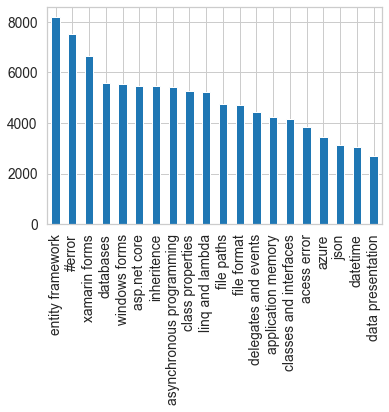

In [165]:
result = df['Topic'].value_counts()
result.plot.bar()

<AxesSubplot:xlabel='Topic'>

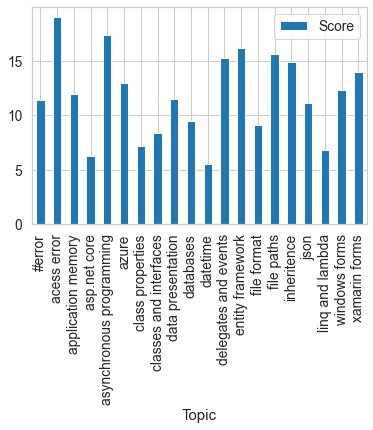

In [166]:
score_mean = df.groupby(['Score', 'Topic']).sum().reset_index().groupby('Topic').mean()
score_mean.plot.bar()

In [ ]:
whiteList = pd.read_csv(
    './csharp-topics.csv',
    encoding='utf-8')
mydict = {}
whiteList['C# documentation'] = whiteList['C# documentation'].str.lower()
for topic in whiteList['C# documentation']:
    mydict[topic] = df['Title'].str.contains(topic, regex=False).sum()

## Data analysis

*Document you choice and motivation for selected data mining method(s) here. Choose a data mining method(s) to use in Python code to perform an analysis of your chosen dataset. Describe why you chose the method(s) and what interesting things you have found from the analysis.*

*Replace the contents of this cell with your own text.*

## Evaluation of results

*Document an evaluation your analysis results and describe how potentially actionable they are.*

*Replace the contents of this cell with your own text.*

In [ ]:
# Add your own code

## Schedule and description of project plan

*Rough schedule for the project beyond the pilot study presented in 3-5. This does not have to be advanced, you can simply provide an estimate based upon reported schedules for similar projects in the literature.*

*Replace the contents of this cell with your own text.*

## Ethical aspects that need to be considered

*Are there ethical aspects that need to be considered? Are there legal implications (e.g., personal data / GDPR)? Are there implications if the case organization is a business, public authority, or nonprofit entity?*

*Replace the contents of this cell with your own text.*